# 1. [Imports](#section1)

# 2. [Détection des sujets d'insatisfaction](#section2)
- [Chargement des données](#section21)
- [Preprocessing des données](#section22)
- [EDA](#section23)
- [Modeling](#section24)

# 3. [Classement d'images non supervisé](#section3)
- [Chargement des données](#section31)
- [Preprocessing des données](#section32)
- [EDA](#section33)
- [Modeling](#section34)

<a id="section1"></a>
# Import

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image, ImageOps
from PIL import ImageFilter
from matplotlib import pyplot as plt
import cv2
from pathlib import Path
import shutil
from PIL import Image
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.collections import Counter
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import pickle
import json
import ssl
import pyLDAvis
from pyLDAvis import lda_model
pyLDAvis.enable_notebook()

try:
    from PIL import UnidentifiedImageError
except ImportError:
    UnidentifiedImageError = IOError

import sys
from pathlib import Path

# Ajout chemin du dossier racine au sys.path
if str(Path().absolute().parents[0]) not in sys.path:
    sys.path.append(str(Path().absolute().parents[0]))
    
from src.data_processing.general_preprocessing import clean_comment, tokenize_comment, delete_stopwords, lemmatized_tokens, most_frequent_word, delete_most_frequent_word, unique_word, delete_unique_word
from src.data_processing.lda_preprocessing import create_bow, create_tfidf
from src.models.lda_tuning import tune_lda
from src.visualization.lda_visualisation import sklearn_print_top_words
from src.utils.api_yelp import search_with_pagination
from src.pipeline import PipelineLDA

In [4]:
pd.set_option('display.max_rows', 500)

<a id="section2"></a>
# 2. Détection des sujets d'insatisfaction

<a id="section21"></a>
## 2.1. Chargement des données

Faire en sorte de prendre un sample avec des 'user_id' unique.

In [5]:
review = pd.read_json("../data/raw/yelp_dataset/yelp_academic_dataset_review.json", lines=True)
business = pd.read_json("../data/raw/yelp_dataset/yelp_academic_dataset_business.json", lines=True)
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [6]:
business_id_restaurants = business.loc[(business['categories'].str.contains(r'Restaurants'))&(~business['categories'].isna()),'business_id'].to_list()

In [7]:
review_sample = review.loc[review['business_id'].isin(business_id_restaurants),:]

Nous passons de 6 990 280 lignes à 4 724 471 lignes concernant des restaurants, dont 567 185 lignes ayant une note de satisfaction d'une étoile.

In [8]:
review_sample = review_sample.loc[review_sample['stars']==1,'text'].sample(n=100000, random_state=0)
review_sample = review_sample.to_frame()

<a id="section22"></a>
## 2.2. Preprocessing des données

In [9]:
# Enregistrement des données brutes au bon format
with open('../data/raw/raw_comments.pkl', 'wb') as f:
    pickle.dump(review_sample['text'], f)

In [10]:
review_sample['clean_comment'] = review_sample['text'].apply(clean_comment)
review_sample['tokens'] = review_sample['clean_comment'].apply(tokenize_comment)
review_sample['tokens_without_stopwords'] = review_sample['tokens'].apply(delete_stopwords)
review_sample['tokens_lemm'] = review_sample['tokens_without_stopwords'].apply(lemmatized_tokens)
top_words = most_frequent_word(review_sample['tokens_lemm'], 20)
review_sample['tokens_without_top_words'] = review_sample['tokens_lemm'].apply(lambda comment: delete_most_frequent_word(comment, top_words))
#unique_word = unique_word(review_sample['tokens_without_top_words'])
#review_sample['tokens_without_unique_word'] = review_sample['tokens_without_top_words'].apply(lambda comment: delete_unique_word(comment, unique_word))

In [11]:
# Enregistrement des top words
with open('../src/models/top_words.json', 'w') as f:
    json.dump(top_words, f)

In [12]:
# Enregistrement des données preprocessed
with open('../data/processed/tokens_without_top_words.pkl', 'wb') as f:
    pickle.dump(review_sample['tokens_without_top_words'], f)

<a id="section23"></a>
## EDA

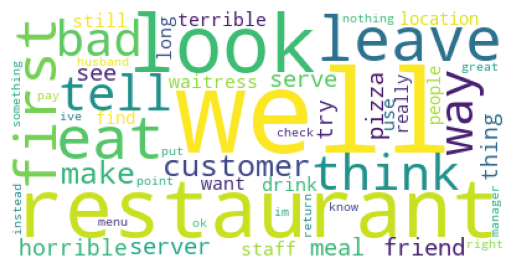

In [13]:
joined_corpus = " ".join([" ".join(word) for word in review_sample['tokens_without_top_words'].values])
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(joined_corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

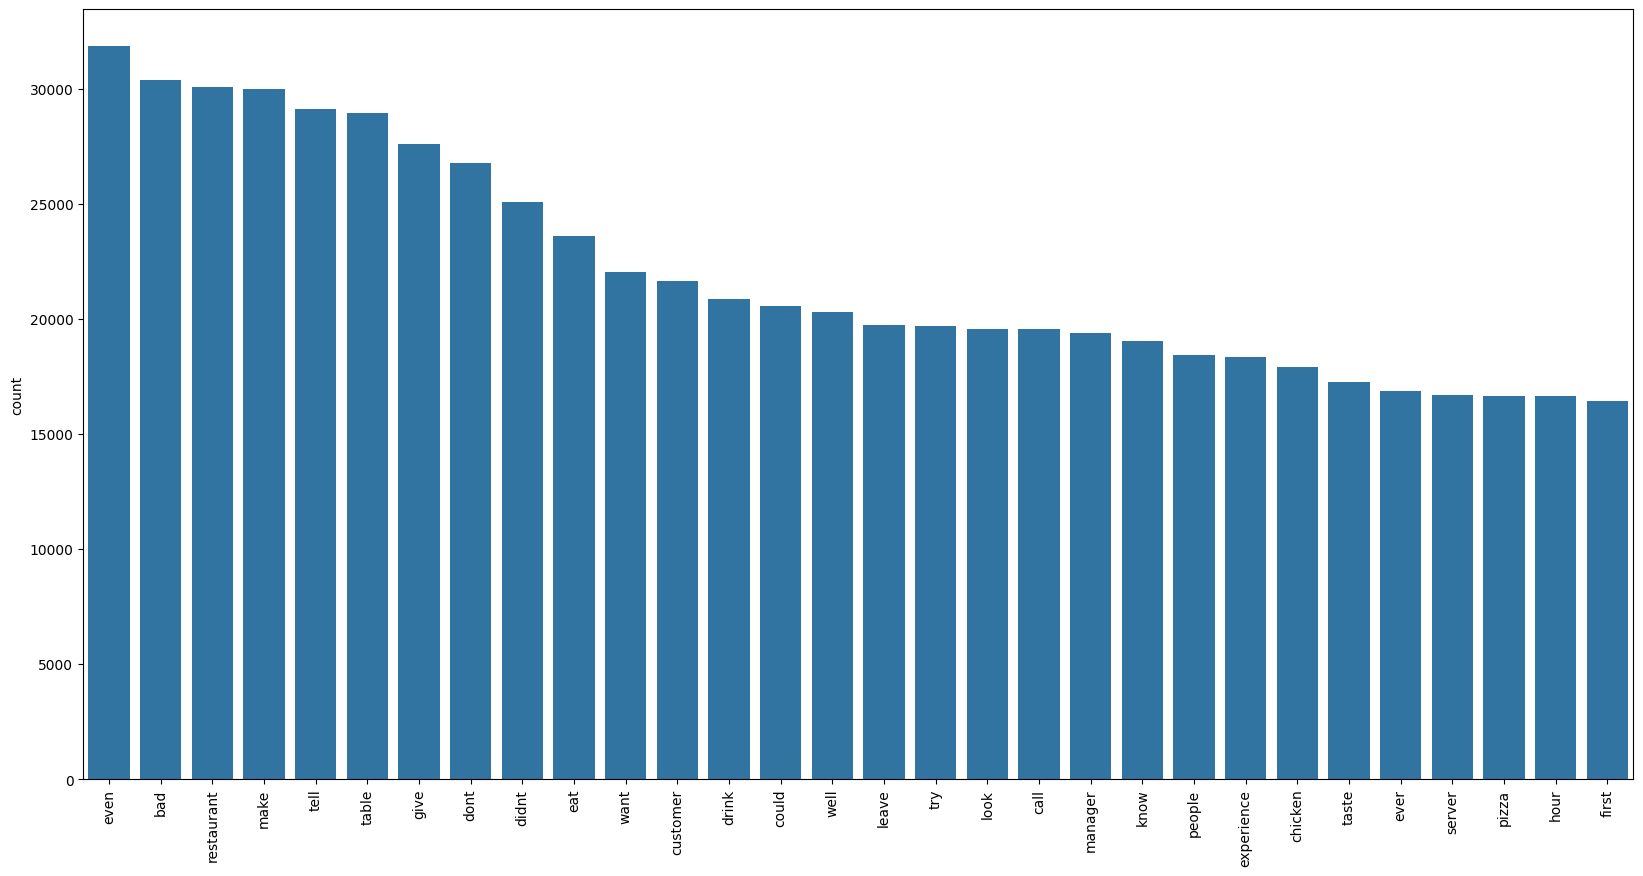

In [14]:
word_freq = pd.Series(joined_corpus.split()).value_counts()
plt.figure(figsize=(20,10))
sns.barplot(word_freq.head(30))
plt.xticks(rotation=90);

In [15]:
review_sample['tokens_without_top_words'].isna().sum()

0

<a id="section24"></a>
## Modeling

Gensim lda tune coherence score: bow, tf-idf
Sklearn lda tune perplexity
Enlever les commentaires non anglophones

### Bag of words : sklearn

In [16]:
# Create bag of words
bow, vectorizer_bow = create_bow(review_sample['tokens_without_top_words'])

In [17]:
# Enregistrement du vectorizer
with open('../src/models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer_bow, f)

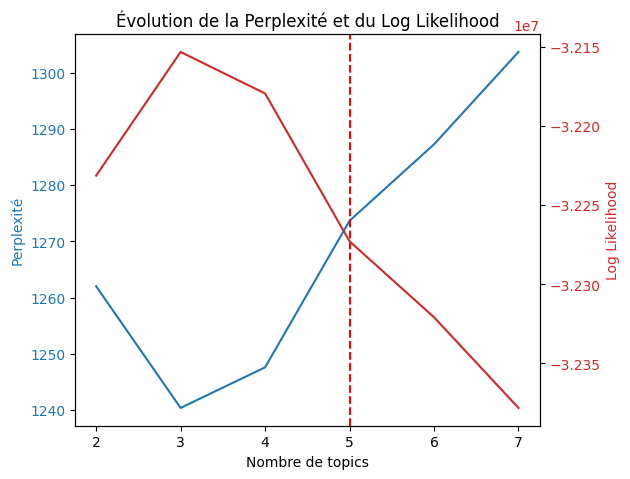

In [18]:
# LDA tuning with perplexity
topic_range = range(2, 8)
best_model_bow, best_num_topics_bow, best_perplexity_bow, best_log_likelihood_bow = tune_lda(bow, topic_range, max_iter=10)

In [19]:
# Si je souhaite entrainer le modèle moi-même
# best_model_bow = train_lda(bow, n_components=5)

In [20]:
sklearn_print_top_words(best_model_bow,vectorizer_bow.get_feature_names_out(), 10)

Topic #0: customer call tell give make dont manager rude know want
Topic #1: pizza chicken cheese sandwich fry burger sauce salad cold wing
Topic #2: taste meal restaurant dish eat menu price steak bad rice
Topic #3: bad dont eat look taco use ive coffee ever restaurant
Topic #4: table drink server leave sit bar even waitress walk restaurant


In [21]:
# Enregistrement du modèle
with open('../src/models/lda_model.pkl', 'wb') as f:
    pickle.dump(best_model_bow, f)

In [22]:
sklearn_print_top_words(best_model_bow,vectorizer_bow.get_feature_names_out(), 15)

Topic #0: customer call tell give make dont manager rude know want business pay even im didnt owner work employee could people
Topic #1: pizza chicken cheese sandwich fry burger sauce salad cold wing taste bread eat bad make give even meat cook slice
Topic #2: taste meal restaurant dish eat menu price steak bad rice well shrimp even cook roll chicken soup plate flavor didnt
Topic #3: bad dont eat look taco use ive coffee ever restaurant dirty really make im think year old staff disgust well
Topic #4: table drink server leave sit bar even waitress walk restaurant tell seat didnt another hour experience check people night could


In [23]:
# Interprétation des topics :
dic_topics = {
    0 : "Relation client du restaurant et problématique avec son staff.",
    1 : "Qualité de la nourriture de manière ciblé, goût déplaisant des aliments, aliments surgelés ou froid.",
    2 : "Qualité de l'établissement, de ses prix, de sa cuisine d'une manière générale.",
    3 : "Qualité de la propreté et expérience gachée pour des questions d'hygiène.",
    4 : "Problématique du temps d'attente et du service."
}

In [24]:
# Enregistrement du dictionnaire d'interprétation des topics
with open('../src/models/dic_topics.json', 'w') as f:
    json.dump(dic_topics, f)

In [25]:
config = {
    'model_path': "../src/models/lda_model.pkl",
    'vectorizer_path': "../src/models/vectorizer.pkl",
    'top_words': top_words,
    'interpreted_topics': dic_topics
}
try:
    pipeline = PipelineLDA(config)
    raw_data = review_sample['text']
    preprocessed_data = pipeline.preprocess_data(raw_data)
    transformed_data = pipeline.transform_data(preprocessed_data)
    most_probable_topics, topic_probabilities = pipeline.predict_topics(transformed_data)
    # Numpy value counts
    unique, counts = np.unique(most_probable_topics, return_counts=True)
    topic_distribution = pd.DataFrame((unique, counts)).T
    topic_distribution.rename(columns={topic_distribution.columns[0]: "Topic", 
                                    topic_distribution.columns[1]: "Nb"}, inplace=True)
    topic_interpretation = topic_distribution["Topic"].map(pipeline.interpreted_topics)
    topic_distribution.insert(loc=1, column="Interpretation", value=topic_interpretation)
    print(topic_distribution)
except ValueError as e:
    print(f"Error : {e}")

[1 3 4 ... 2 0 2]
--------------------------------------------------
[[0.16883549 0.31931571 0.27965868 0.19077473 0.04141539]
 [0.0203417  0.02012031 0.02030372 0.91901888 0.02021539]
 [0.02025931 0.02031393 0.02065361 0.02039646 0.9183767 ]
 ...
 [0.0036352  0.0036224  0.52858344 0.15810745 0.30605151]
 [0.52952636 0.06724392 0.09881769 0.09269605 0.21171598]
 [0.00891056 0.00887918 0.56064028 0.41268585 0.00888412]]


In [49]:
topic_distribution

,Topic,Interpretation,Nb
0,0,Relation client du restaurant et problématique...,28557
1,1,"Qualité de la nourriture de manière ciblé, goû...",10132
2,2,"Qualité de l'établissement, de ses prix, de sa...",20320
3,3,Qualité de la propreté et expérience gachée po...,12843
4,4,Problématique du temps d'attente et du service.,28148


In [48]:
topic_interpretation = topic_distribution["Topic"].map(pipeline.interpreted_topics)
topic_distribution.insert(loc=1, column="Interpretation", value=topic_interpretation)

TypeError: unhashable type: 'numpy.ndarray'

In [47]:
topic_distribution["Topic"].values[0]

0

In [30]:
pipeline.interpreted_topics[most_probable_topics[0]]

'Qualité de la nourriture de manière ciblé, goût déplaisant des aliments, aliments surgelés ou froid.'

In [27]:
pipeline.interpreted_topics

{0: 'Relation client du restaurant et problématique avec son staff.',
 1: 'Qualité de la nourriture de manière ciblé, goût déplaisant des aliments, aliments surgelés ou froid.',
 2: "Qualité de l'établissement, de ses prix, de sa cuisine d'une manière générale.",
 3: "Qualité de la propreté et expérience gachée pour des questions d'hygiène.",
 4: "Problématique du temps d'attente et du service."}

In [27]:
panel_bow = lda_model.prepare(best_model_bow, bow, vectorizer_bow, mds='tsne')
pyLDAvis.display(panel_bow)

### TF-IDF : sklearn

In [28]:
# Create bag of words
tfidf, vectorizer_tfidf = create_tfidf(review_sample['tokens_without_top_words'])

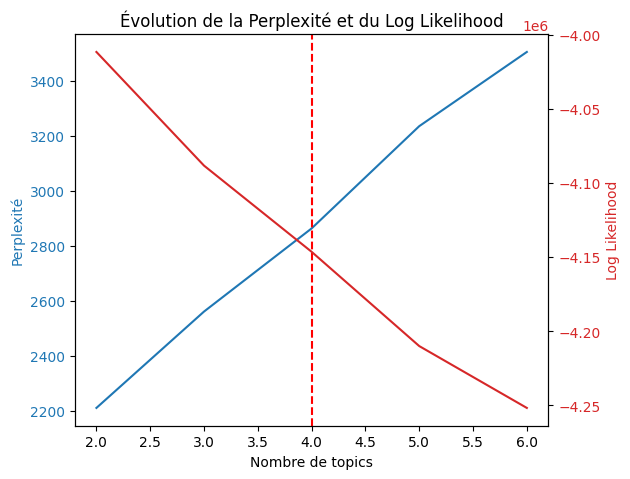

In [29]:
# LDA tuning with perplexity
topic_range = range(2, 7)
best_model_tfidf, best_num_topics_tfidf, best_perplexity_tfidf, best_log_likelihood_tfidf = tune_lda(tfidf, topic_range, max_iter=10)

Décision basée sur le graphique et non sur les chiffres.

In [30]:
#best_params_sklearn_bow = 2
best_params_sklearn_tfidf = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online', random_state=100).fit(tfidf)

In [31]:
sklearn_print_top_words(best_params_sklearn_tfidf, vectorizer_tfidf.get_feature_names_out(), 15)

Topic #0: table tell customer drink restaurant manager even leave make people server bad give didnt rude
Topic #1: pizza call drive delivery hour location phone thru close online deliver pick mcdonalds burrito dont
Topic #2: chicken taste fry cheese bad sauce eat burger salad meat sandwich cook rice dry flavor
Topic #3: dirty coffee bathroom clean trash mask smell wear disgust bagel breakfast floor hand filthy fly


Interprétation des topics :
Topic 0 : Relation client du restaurant et problématique avec son staff.
Topic 1 : Problématique de livraison, d'attente et de contact à distance avec le restaurant.
Topic 2 : Qualité de la nourriture de manière ciblé, goût déplaisant des aliments, aliments surgelés ou froid.
Topic 3 : Qualité de la propreté et expérience gachée pour des questions d'hygiène.

In [32]:
review_sample.head()

,text,clean_comment,tokens,tokens_without_stopwords,tokens_lemm,tokens_without_top_words
3155066,I have a laundry list of issues with this plac...,i have a laundry list of issues with this plac...,"[i, have, a, laundry, list, of, issues, with, ...","[laundry, list, issues, place, boil, salads, e...","[laundry, list, issue, place, boil, salad, exp...","[laundry, list, issue, boil, salad, expensive,..."
5796398,"I expected better food, after being in NO for ...",i expected better food after being in no for a...,"[i, expected, better, food, after, being, in, ...","[expected, better, food, days, shame, airport,...","[expect, well, food, day, shame, airport, does...","[expect, well, day, shame, airport, doesnt, ke..."
2221781,"Worst dinner experience, drinks and food was g...",worst dinner experience drinks and food was go...,"[worst, dinner, experience, drinks, and, food,...","[worst, dinner, experience, drinks, food, good...","[bad, dinner, experience, drink, food, good, b...","[bad, dinner, experience, drink, bit, dinner, ..."
3226366,"Hello my fellow yelpers, word to the wise don'...",hello my fellow yelpers word to the wise dont ...,"[hello, my, fellow, yelpers, word, to, the, wi...","[hello, fellow, yelpers, word, wise, dont, try...","[hello, fellow, yelpers, word, wise, dont, try...","[hello, fellow, yelpers, word, wise, dont, try..."
2684804,"Do not go here you will be sorry or sick, I wa...",do not go here you will be sorry or sick i war...,"[do, not, go, here, you, will, be, sorry, or, ...","[go, sorry, sick, warned, place, anymore, owne...","[go, sorry, sick, warn, place, anymore, owners...","[sorry, sick, warn, anymore, ownership, change..."


Interprétation des topics :
- Sujet en lien avec le contact client
- Sujet en lien avec le temps d'attente et la qualité de la nourriture / boisson

In [33]:
panel_tfidf = lda_model.prepare(best_model_tfidf, tfidf, vectorizer_tfidf, mds='tsne')
pyLDAvis.display(panel_tfidf)

In [36]:
from src.pipeline import lda
data_test = review_sample.loc[3022807,'text']

try:
    results = lda(data_test)
except ValueError as e:
    print(f"Error : {e}")

TypeError: unhashable type: 'numpy.ndarray'

In [38]:
dic_topics[1]

'Qualité de la nourriture de manière ciblé, goût déplaisant des aliments, aliments surgelés, problématique de chaleur (froid).'

## Get reviews from Yelp API

In [ ]:
# Ne pas récupérer que les commentaires négatifs
restaurants = search_with_pagination(term="restaurants", location="New York, NY", total=1500)
data = []  # Liste pour stocker les données

for restaurant in restaurants:
    business_id = restaurant['id']
    reviews = get_review(business_id)

    if reviews and 'reviews' in reviews:
        for review in reviews['reviews']:
            if review['rating'] <= 3:  # Filtrer pour ne garder que les avis avec un rating de 1
                data.append({'business_id': business_id, 'review': review['text'], 'rating': review['rating']})
    else:
        print(f"Aucun avis disponible pour le restaurant {business_id}.\n")

# Créer un DataFrame à partir de la liste de dictionnaires
reviews_from_api = pd.DataFrame(data)

In [21]:
reviews_from_api

,business_id,review,rating
0,MGd6HFEq1ALD58XWNviSXw,This is literally just a tourist trap. There's...,2
1,OwDRIugcA4LkUuTRqpJsog,Had an awful experience tonight. Chicken came ...,1
2,m4CFfE1_u5rwVgb45ZqRpA,I never write reviews but this time i felt is ...,1
3,ipAsHykRvgJzpx5hD8vTJw,Really nice place for a quick bite. The onigir...,2
4,rp8S7scxOkVVeG7dNneMGQ,Update-\n\nAs y'all know (based on my previous...,1
...,...,...,...
77,eOLHik1-6IqTiebYRIIWpA,The unique location and presentations of each ...,1
78,mlGfXoxc8cEss8Yms6VrXg,The cashier was very nice and had a very pleas...,2
79,r-EDS_eO70HUgDmOk5_8Qw,The atmosphere and ambiance was good at first ...,2
80,rJ4N10Nbh-GM49qOSGFoAw,It hurts my heart and soul and taste buds that...,2


In [24]:
pd.DataFrame(reviews_from_api['review'])

,0
0,I went to see dr swing since I was 12 week pre...


In [28]:
import pickle
from pathlib import Path
import pandas as pd
from src.data_processing.general_preprocessing import clean_comment, tokenize_comment, delete_stopwords, lemmatized_tokens, delete_most_frequent_word

top_words_path = "../src/models/top_words.pkl"
vectorizer_path = "../src/models/vectorizer.pkl"
model_path = "../src/models/lda_model.pkl"

with open(top_words_path, 'rb') as f:
    top_words = pickle.load(f)

with open(vectorizer_path, 'rb') as f:
    vectorizer = pickle.load(f)

with open(model_path, 'rb') as f:
    lda_model = pickle.load(f)

data_source = reviews_from_api['review']

data_transformed = pd.DataFrame(data_source)

data_transformed['clean_comment'] = data_transformed['review'].apply(clean_comment)
data_transformed['tokens'] = data_transformed['clean_comment'].apply(tokenize_comment)
data_transformed['tokens_without_stopwords'] = data_transformed['tokens'].apply(delete_stopwords)
data_transformed['tokens_lemm'] = data_transformed['tokens_without_stopwords'].apply(lemmatized_tokens)
data_transformed['tokens_without_top_words'] = data_transformed['tokens_lemm'].apply(lambda comment: delete_most_frequent_word(comment, top_words))

bow = vectorizer.transform(data_transformed['tokens_without_top_words'].apply(" ".join))
feature_names = vectorizer.get_feature_names_out()

# Transformation avec LDA
topic_probabilities = lda_model.transform(bow)

# Trouver le topic le plus probable pour chaque document
most_probable_topics = topic_probabilities.argmax(axis=1)

# Ajouter les résultats au DataFrame
data_transformed['most_probable_topic'] = most_probable_topics
data_transformed['topic_probability'] = topic_probabilities.max(axis=1)

# Afficher les résultats
print(data_transformed[['review', 'most_probable_topic', 'topic_probability']])

# Obtenir les mots clés pour chaque topic
n_top_words = 10
for topic_idx, topic in enumerate(lda_model.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


                                               review  most_probable_topic  \
0   This is literally just a tourist trap. There's...                    3   
1   Had an awful experience tonight. Chicken came ...                    0   
2   I never write reviews but this time i felt is ...                    4   
3   Really nice place for a quick bite. The onigir...                    3   
4   Update-\n\nAs y'all know (based on my previous...                    0   
..                                                ...                  ...   
77  The unique location and presentations of each ...                    2   
78  The cashier was very nice and had a very pleas...                    0   
79  The atmosphere and ambiance was good at first ...                    4   
80  It hurts my heart and soul and taste buds that...                    3   
81  ***2 1/2 stars***\n\nThis just wasn't my cup o...                    4   

    topic_probability  
0            0.662439  
1            0.

In [3]:
from src.pipeline import lda

results = lda(review_sample['tokens_without_top_words'])

ModuleNotFoundError: No module named 'data_processing'

In [4]:
# Enregistrement des données preprocessed
with open('../data/processed/tokens_without_top_words.pkl', 'wb') as f:
    pickle.dump(review_sample['tokens_without_top_words'], f)

NameError: name 'review_sample' is not defined

## Pipeline

Modularité du pipeline : 
- Dagster 
- Airflow
- Spark : contraintes de rapidité

Création d'une class homemade pour structurer le code.

Nouveau comm : probabilité d'appartenance à chaque topic --> Choix du topic

Page web : 
Dashboard : zone de texte + bouton -> prediction du topic associé (Streamlit)
API : récupération des commentaires (graphql, requests ?)
- Requête 1 : Liste des restaurants choisi
- Requête 2 : Récupérer les reviews

In [ ]:
pipeline.transform(new_data)

In [ ]:
class CleanCommentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(clean_comment)

class TokenizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(tokenize_comment)

class RemoveStopwordsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(delete_stopwords)

class LemmatizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lemmatized_tokens)

In [ ]:
class BOWTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=5000):
        self.max_features = max_features
        self.vectorizer = None

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(max_features=self.max_features)
        self.vectorizer.fit(X.apply(" ".join))
        return self

    def transform(self, X):
        return self.vectorizer.transform(X.apply(" ".join))

class TFIDFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=5000):
        self.max_features = max_features
        self.vectorizer = None

    def fit(self, X, y=None):
        self.vectorizer = TfidfVectorizer(max_features=self.max_features)
        self.vectorizer.fit(X.apply(" ".join))
        return self

    def transform(self, X):
        return self.vectorizer.transform(X.apply(" ".join))

In [ ]:
# Pipeline pour le prétraitement textuel
preprocessing_pipeline = Pipeline([
    ('clean', CleanCommentTransformer()),
    ('tokenize', TokenizeTransformer()),
    ('remove_stopwords', RemoveStopwordsTransformer()),
    ('lemmatize', LemmatizeTransformer()),
    # Ajouter ici les autres transformateurs personnalisés si nécessaire
])

# Pipeline complet avec BoW ou TF-IDF et LDA
bow_lda_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('bow', BOWTransformer()),
    ('lda', LatentDirichletAllocation(n_components=10, random_state=0))
])

tfidf_lda_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('tfidf', TFIDFTransformer()),
    ('lda', LatentDirichletAllocation(n_components=10, random_state=0))
])

<a id="section3"></a>
# 3. Classement d'images non supervisé

<a id="section31"></a>
## 3.1. Chargement des données

In [8]:
img_folder = Path("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos")
img_folder_sample = img_folder / "sample"
img_folder_sample.mkdir(exist_ok=True)
dest_path = img_folder_sample / "processed_images"
ssl._create_default_https_context = ssl._create_unverified_context

FileNotFoundError: [Errno 2] No such file or directory: '/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos/sample'

In [ ]:
photo = pd.read_json("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos.json", lines=True)

In [39]:
checkin = pd.read_json("../data/raw/yelp_dataset/yelp_academic_dataset_checkin.json", lines=True)
review = pd.read_json("../data/raw/yelp_dataset/yelp_academic_dataset_review.json", lines=True)
tip = pd.read_json("../data/raw/yelp_dataset/yelp_academic_dataset_tip.json", lines=True)
user = pd.read_json("../data/raw/yelp_dataset/yelp_academic_dataset_user.json", lines=True)

Extraction de descripteurs : 
- Descripteurs manuels / traditionnels : SIFT, ORB, SURF. Reconstruction de scène 3D, d'image.
- Deeplearning : reconnaissance d'image, classification

Objectif: Estimer la faisabilité : comparaison des clusters aux vrais labels. Indice ARI : sous estimation de la performance de notre modèle avec cette metric.

Extraire les descripteurs : extraction des points d'intéret avec un vecteur descriptor qui représente ces points d'intérêts. 
Clustering sur ces descripteurs : identification des caractéristiques de l'ensemble de mes images
Pour obtenir un vecteur par image on utilise des visual bag of words : on compte le nombre de fois où on trouve une caractéristique dans une image : faire un predict sur mon image
Clustering de ces vecteurs d'image.
Calculer l'ARI

Deeplearning : ResNET
JV : calcul matricielle, réseau de neurone : calcul matricielle -> tous les 2 sur carte graphique
GPU : camion, distribuer les calculs
CPU : ferrari

<a id="section32"></a>
## 3.2. Preprocessing des données

In [ ]:
LABELS = list(photo['label'].unique())

In [ ]:
def select_and_copy_images(dataframe, source_path:Path, dest_path:Path, num_images:int):
    sample = pd.DataFrame(columns=dataframe.columns)

    for label in dataframe['label'].unique():
        sample = pd.concat([sample, dataframe.loc[dataframe['label']==label,:].sample(n=num_images)])
    
    print(f"Taille de l'échantillon : {len(sample)}")

    # Copying selected images to sample folder
    for img in source_path.glob('*.jpg'):
        if img.stem in sample['photo_id'].to_list():
            shutil.copyfile(img, dest_path / img.name)
            sample.loc[sample['photo_id'] == img.stem, 'path'] = str(img)
    
    return sample

def jpg_to_png(img_path:Path) -> Path:
    # Create png dir if not exist
    png_folder = img_path.parent / "png_img"
    png_folder.mkdir(exist_ok=True)
    
    # Log error file if not exist
    log_error_file = png_folder / "log_errors.txt" 
    log_error_file.touch(exist_ok=True)

    if img_path.suffix == '.jpg':
        try:
            with Image.open(img_path) as img:
                png_img = img_path.stem + ".png"
                img.save(png_folder / png_img, "PNG")
                png_img = Path(png_folder.absolute() / png_img)
                return png_img
        except IOError as e:
            with open(log_error_file, 'a') as file:
                file.write(f"Impossible de traiter l'image {img_path.name}: {e}")

    else:
        return img_path
    
def process_images(directory:Path, batch_size=100):
    # Get the list of images
    images = list(directory.glob('*.jpg'))

    # Create destination dir if not exist
    dest_folder = directory / "processed_images"
    dest_folder.mkdir(exist_ok=True)

    # Create file for record errors if not exist
    error_file = dest_folder / "errors.txt"   
    error_file.touch(exist_ok=True)

    for i in range(0, len(images), batch_size):
        for img_path in images[i: i + batch_size]:

            # Conversion to png if necessary
            img_path = jpg_to_png(img_path)

            try:
                img = Image.open(img_path)
                img.verify()
            except (UnidentifiedImageError, IOError):
                with open(error_file, 'a') as file:
                    file.write(f"Le fichier {img_path} n'a pas pu être identifié comme une image valide.")
                continue
            
            img = Image.open(img_path)

            # Median filter --> Gaussien filter instead
            img = img.filter(ImageFilter.MedianFilter(size=3))

            # Equalize histogram
            img = ImageOps.equalize(img)

            # Path destination
            dest_path = dest_folder / img_path.name

            # Save image processed
            img.save(dest_path)

            # Free memory
            img.close()

def sift_features(directory:Path, batch_size=100):
    destination_path = directory / 'sift'
    destination_path.mkdir(exist_ok=True)
    
    # Create SIFT detector
    sift = cv2.SIFT_create()

    batch_num = 0
    batch_descriptors = list()
    images_files = list(directory.glob('*.png'))
    total_images = len(images_files)
    images_processed = 0
    image_names = list()

    # Pour le diagnostic
    descriptor_count = {}

    # Iterate over all images
    for i, img_path in enumerate(images_files):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        keypoints, descriptors = sift.detectAndCompute(img, None)

        if descriptors is not None:
            batch_descriptors.extend(descriptors)
            for _ in range(len(descriptors)):
                image_names.append(img_path.stem)

            # Ajout dans le dictionnaire pour le diagnostic
            descriptor_count[img_path.stem] = len(descriptors)

            images_processed += 1
        
        if images_processed >= batch_size or i == total_images - 1:
            # Concatenate all numpy array in batch_descriptors in one numpy array
            descriptors_to_save = np.vstack(batch_descriptors)
            descriptor_path = destination_path / f"descriptors_batch_{batch_num}.npy"
            image_names_path = destination_path / f"images_names_batch_{batch_num}.npy"
            np.save(image_names_path, np.array(image_names))
            np.save(descriptor_path, descriptors_to_save)
            batch_descriptors = list()
            images_processed = 0
            batch_num += 1
            image_names = list()

    # # Afficher les statistiques de descripteurs
    # print("Nombre de descripteurs par image :")
    # for photo_id, count in descriptor_count.items():
    #     print(f"{photo_id}: {count}")

    return batch_num

def load_descriptors(directory:Path):
    descriptor_files = list(directory.glob('descriptors_batch_*.npy'))

    all_descriptors = [np.load(file) for file in descriptor_files]

    all_descriptors_stacked = np.vstack(all_descriptors)

    return all_descriptors_stacked

def elbow_method(descriptors, range_n_clusters):
    inertia = list()

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(descriptors)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range_n_clusters, inertia, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

def apply_pca_and_kmean(descriptors, n_components=None, n_clusters=100):
    # Descriptors normalisation before ACP
    scaler = StandardScaler()
    descriptors_scaled = scaler.fit_transform(descriptors)

    # Apply ACP
    pca = PCA(n_components=n_components, random_state=42)
    descriptors_pca = pca.fit_transform(descriptors_scaled)

    # Apply Kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(descriptors_pca)

    return pca, kmeans, kmeans.cluster_centers_, descriptors_pca

def create_photo_cluster_table(directory, kmeans_labels):
    # Load images
    image_names_files = list(Path(directory).glob('images_names_batch_*.npy'))
    image_names = [np.load(file) for file in image_names_files]
    image_names = np.concatenate(image_names)

    # Create Dataframe
    photo_cluster_df = pd.DataFrame({
        'photo_id' : image_names,
        'cluster_label' : kmeans_labels
    })
    
    # Get the most frequent cluster by photo
    photo_cluster_df = photo_cluster_df.groupby('photo_id')['cluster_label'].agg(lambda x: x.value_counts().index[0])

    # Reset index to turn the Series back into a DataFrame
    photo_cluster_df = photo_cluster_df.reset_index()

    return photo_cluster_df

In [ ]:
photo_sample = select_and_copy_images(photo, img_folder, img_folder_sample, 200)

In [ ]:
process_images(img_folder_sample)

In [ ]:
batch_sift = sift_features(dest_path)

In [ ]:
img_folder_sample_sift = dest_path / "sift"

In [ ]:
# Load descriptors and train KMeans with k = 5 because we have 5 categories of photo
descriptors = load_descriptors(img_folder_sample_sift)
pca_model, kmeans_model, cluster_center, descriptors_pca = apply_pca_and_kmean(descriptors, n_components=0.80, n_clusters=5)

In [ ]:
elbow_method(descriptors, range(2,10));

In [ ]:
photo_cluster_df = create_photo_cluster_table(img_folder_sample_sift, kmeans_model.labels_)

In [ ]:
encoder = LabelEncoder()
photo['label_numeric'] = encoder.fit_transform(photo['label'])
comparison_df = photo_cluster_df.merge(photo[['photo_id','label_numeric']], left_on='photo_id', right_on='photo_id')
#cluster_mod = comparison_df.groupby('cluster_label')['label_numeric'].agg(lambda x: x.mode()[0])
#comparison_df['predicted_category'] = comparison_df['cluster_label'].map(cluster_mod)

In [ ]:
# Utilisation de la fonction crosstab pour créer la matrice de correspondance
correspondence_matrix = pd.crosstab(comparison_df['label_numeric'], comparison_df['cluster_label'])

# Affichage de la matrice de correspondance
print(correspondence_matrix)

# Visualisation de la matrice de correspondance en tant que heatmap
sns.set(context='talk', style='whitegrid')
plt.figure(figsize=(10,8))
sns.heatmap(correspondence_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')
plt.title('Correspondence Matrix Heatmap')
plt.show();

In [ ]:
#conf_matrix = confusion_matrix(comparison_df['label_numeric'], comparison_df['predicted_category'])

# labels = encoder.classes_
# sns.set(context='talk', style='whitegrid')
# plt.figure(figsize=(10,8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.title('Matrice de Confusion')
# plt.xlabel('Prédictions')
# plt.ylabel('Véritables Étiquettes')
# plt.show()

In [ ]:
ari_score = adjusted_rand_score(comparison_df['label_numeric'], comparison_df['cluster_label'])
print("Adjusted Rand Index:", ari_score)

In [ ]:
pca_model, kmeans_model, cluster_center, descriptors_pca = apply_pca_and_kmean(descriptors, n_components=0.80, n_clusters=5)


In [ ]:
def visualize_clusters_with_tsne(descriptors_pca, kmeans_labels, perplexity=30, n_iter=1000):
    # Apply t-SNE on descriptors
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    descriptors_tsne = tsne.fit_transform(descriptors_pca)

    # Visualisation
    plt.figure(figsize=(10, 10))
    unique_labels = np.unique(kmeans_labels)
    for label in unique_labels:
        cluster_descriptors = descriptors_tsne[kmeans_labels == label]
        plt.scatter(cluster_descriptors[:, 0], cluster_descriptors[:, 1], label=f'Cluster {label}')

In [ ]:
# Avec 5 clusters
#visualize_clusters_with_tsne(descriptors_pca, kmeans_model.labels_)

# CNN unsupervised

In [ ]:
# Diviser le DataFrame de manière stratifiée
train_df, validation_df = train_test_split(
    photo_sample, 
    test_size=0.2,
    stratify=photo_sample['label'],
    random_state=42
)

In [ ]:
# Set paths for architecture folder
cnn_folder = Path("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos/cnn")
cnn_folder.mkdir(exist_ok=True)

train_folder = Path("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos/cnn/train")
train_folder.mkdir(exist_ok=True)

validation_folder = Path("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos/cnn/validation")
validation_folder.mkdir(exist_ok=True)

# Copy images
for label in LABELS :
    train_label_path = train_folder / label
    train_label_path.mkdir(exist_ok=True)
    validation_label_path = validation_folder / label
    validation_label_path.mkdir(exist_ok=True)

    for img in img_folder.glob('*.jpg'):
        if img.stem in train_df['photo_id'].to_list() and train_df.loc[train_df['photo_id']==img.stem,'label'].values == label:
            shutil.copyfile(img, train_label_path / img.name)
        elif img.stem in validation_df['photo_id'].to_list() and validation_df.loc[validation_df['photo_id']==img.stem,'label'].values == label:
            shutil.copyfile(img, validation_label_path / img.name)

In [ ]:
#shutil.rmtree(train_folder)
#shutil.rmtree(validation_folder)

In [ ]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Créer un ImageDataGenerator pour le prétraitement
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

In [ ]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 5))

    generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory,
        target_size=(224, 224),
        batch_size = batch_size, 
        class_mode='categorical')
    
    i = 0
    labels_name = list(generator.class_indices.keys())
    
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch

        i += 1
        
        if i * batch_size >= sample_count:
            break

    return features, labels, labels_name

In [ ]:
train_features, train_labels, train_labels_name = extract_features(train_folder, 800)

In [ ]:
validation_features, validation_labels, validation_labels_name = extract_features(validation_folder, 200)

In [ ]:
train_features = np.reshape(train_features, (800, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (200, 7 * 7 * 512))

In [ ]:
model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=25,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training accuracy')
axes[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
# Prédire les étiquettes pour l'ensemble de validation
val_predictions = model.predict(validation_features)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Obtenir les vraies étiquettes de l'ensemble de validation
true_labels = validation_labels.argmax(1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, val_predicted_labels)

# Afficher la matrice de confusion
sns.set(context='talk', style='whitegrid')
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_labels_name, yticklabels=train_labels_name)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables Étiquettes')
plt.show()

# CNN

In [ ]:
photo_sample['label'].value_counts()

In [ ]:
# Diviser le DataFrame de manière stratifiée
train_df, validation_df = train_test_split(
    photo_sample, 
    test_size=0.2,
    stratify=photo_sample['label'],
    random_state=42
)

In [ ]:
# Créer un ImageDataGenerator pour le prétraitement
datagen = ImageDataGenerator(rescale=1./255)

# Créer le train_generator avec train_df
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=img_folder_sample,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Créer le validation_generator avec validation_df
validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=img_folder_sample,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

In [ ]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base pour ne pas les réentraîner
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Créer un modèle séquentiel
model = Sequential()

# Ajouter le modèle de base
model.add(base_model)

# Ajouter des nouvelles couches
model.add(Flatten())

# Ajouter une couche Dense avec régularisation L2
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Ajouter une couche Dense avec régularisation L2
model.add(Dense(64, activation='relu'))

# Augmenter le taux de dropout pour plus de régularisation
model.add(Dropout(0.5))

# La dernière couche Dense pour la classification finale, pas besoin de régularisation ici
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Obtenir les noms et indices des classes
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Identifier les classes uniques et leurs fréquences dans le générateur
unique_classes, class_counts = np.unique(train_generator.classes, return_counts=True)

# Calculer les poids pour les classes uniques
class_weights = compute_class_weight(
    'balanced',
    classes=unique_classes,
    y=train_generator.classes)

# Créer un dictionnaire de poids de classe en fonction des noms de classe
class_weights_dict = {class_names[class_idx]: weight for class_idx, weight in zip(unique_classes, class_weights)}

# Ajuster les poids de classe en fonction des indices réels
adjusted_class_weights = {class_indices[class_name]: weight for class_name, weight in class_weights_dict.items()}

# Ajouter manuellement un poids par défaut pour toute classe manquante
for class_name, class_index in class_indices.items():
    if class_index not in adjusted_class_weights:
        adjusted_class_weights[class_index] = np.mean(list(class_weights_dict.values()))

# Vérifier les poids ajustés
print(adjusted_class_weights)


In [ ]:
# Nombre d'époques pour l'entraînement
epochs = 10

# Entraîner le modèle avec les poids des classes ajustés
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=adjusted_class_weights)

In [ ]:
# Tracer l'accuracy d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy au Cours des Époques')
plt.ylabel('Accuracy')
plt.xlabel('Époque')
plt.legend()
plt.show()

In [ ]:
# Créer un nouveau générateur de validation pour les prédictions sans mélange
validation_generator_for_pred = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=img_folder_sample,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important pour garder le même ordre
)

# Prédire les étiquettes pour l'ensemble de validation
val_predictions = model.predict(validation_generator_for_pred)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Obtenir les vraies étiquettes de l'ensemble de validation
true_labels = validation_generator_for_pred.classes

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, val_predicted_labels)

# Obtenir les noms des classes pour les étiquettes de l'axe
class_labels = list(validation_generator_for_pred.class_indices.keys())

# Afficher la matrice de confusion
sns.set(context='talk', style='whitegrid')
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables Étiquettes')
plt.show()

In [ ]:
# Prédire les étiquettes pour l'ensemble de validation avec shuffle=False
val_predictions = model.predict(validation_generator_for_pred)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Obtenir les vraies étiquettes de l'ensemble de validation
true_labels = validation_generator_for_pred.classes

# Calculer l'Adjusted Rand Index
ari_score = adjusted_rand_score(true_labels, val_predicted_labels)

print(f"L'Adjusted Rand Index est : {ari_score}")

In [ ]:
def predict_image(model, img_path, target_size=(224,224)):
    # Charger et prétraiter l'image
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisation

    # Prédiction
    prediction = model.predict(img_array)

    class_indices = train_generator.class_indices
    classes = list(class_indices.keys())

    # Obtenir le label de la classe avec la plus haute probabilité
    predicted_class = classes[np.argmax(prediction)]

    print(f"Classe prédite pour l'image: {predicted_class}")

    return prediction

# Essais

In [ ]:
# Création d'une instance de SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Fonction pour obtenir le score de sentiment
def get_vader_sentiment(comment):
    # Calcul des scores de sentiment
    sentiment_dict = sia.polarity_scores(comment)
    # Retourne le score 'composé' qui est une métrique globale de sentiment
    return sentiment_dict['compound']

# Application de cette fonction aux commentaires nettoyés
review_sample['vader_sentiment'] = review_sample['cleaned_comment'].apply(get_vader_sentiment)

In [ ]:
def remove_most_frequent_words(text:str, n:int):
    most_freq_words = pd.Series(corpus.split()).value_counts().head(n).index
    return ' '.join(word for word in text.split() if word not in most_freq_words)

corpus_witout_freq_word = remove_most_frequent_words(corpus, 20)
word_freq_2 = pd.Series(corpus_witout_freq_word.split()).value_counts()
word_freq_2